# 环境配置与数据加载

In [1]:
# 基础数据处理库
import pandas as pd
import numpy as np

# 可视化库
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # 导入 mpatches 用于创建图例
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

# --- 美化配置 ---

FONT_TO_USE = 'Microsoft YaHei' # Windows 默认字体
try:
    plt.rcParams['font.sans-serif'] = [FONT_TO_USE]
    plt.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"警告：设置中文字体 '{FONT_TO_USE}' 失败。图表中的中文可能显示为方框。")

penguin_palette = {
    'Adelie': '#FF8C00',     # 橙色 (DarkOrange)
    'Chinstrap': '#A034F0',  # 紫色 (Purple)
    'Gentoo': '#0C7991'      # 蓝绿色 (Teal)
}


species_name_map = {
    'Adelie': '阿德利企鹅',
    'Chinstrap': '帽带企鹅',
    'Gentoo': '巴布亚企鹅'
}


penguin_palette_zh = {species_name_map[k]: v for k, v in penguin_palette.items()}

sex_palette = {
    'MALE': '#1f77b4',       # 蓝色
    'FEMALE': '#ff7f0e'      # 橙色
}
sex_name_map = {
    'MALE': '男企鹅',
    'FEMALE': '女企鹅'
}
sex_palette_zh = {sex_name_map[k]: v for k, v in sex_palette.items()}


# 6. 设置全局 Seaborn 风格
sns.set_theme(
    style="whitegrid",         # 风格：白色网格背景
    context="paper",           # 上下文
    font_scale=1.3,            # 全局字体缩放
    font=FONT_TO_USE,          # 指定中文字体
)


df = pd.read_csv('penguins_size.csv')

if not df.empty:
    print("数据集前5行：")
    print(df.head())
    print("\n数据集维度（行×列）：", df.shape)
    print("\n字段类型与非空值统计：")
    df.info()

数据集前5行：
  species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7              181.0   
1  Adelie  Torgersen              39.5             17.4              186.0   
2  Adelie  Torgersen              40.3             18.0              195.0   
3  Adelie  Torgersen               NaN              NaN                NaN   
4  Adelie  Torgersen              36.7             19.3              193.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
3          NaN     NaN  
4       3450.0  FEMALE  

数据集维度（行×列）： (344, 7)

字段类型与非空值统计：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    fl

# 数据预处理 (第1部分：清洗与衍生)

In [2]:
# 统计缺失值
missing_info = df.isnull().sum()
missing_ratio = (missing_info / len(df)) * 100
missing_df = pd.DataFrame({
    '缺失值数量': missing_info,
    '缺失比例(%)': missing_ratio.round(2)
})
print("\n缺失值统计：")
print(missing_df[missing_df['缺失值数量'] > 0])

# 处理缺失值（直接删除）
df_clean = df.dropna().copy() # 使用 .copy() 避免警告
print(f"\n删除缺失值后数据量：{df_clean.shape[0]} 行")

# 识别并修正异常值（如sex字段的"."）
print("\nsex字段唯一值（修正前）：", df_clean['sex'].unique())
df_clean = df_clean[df_clean['sex'] != '.'].copy()  # 过滤异常值"."
print(f"修正sex异常值后数据量：{df_clean.shape[0]} 行")
print("sex字段唯一值（修正后）：", df_clean['sex'].unique())

# 创建衍生特征（用于分析）
df_clean['culmen_ratio'] = df_clean['culmen_length_mm'] / df_clean['culmen_depth_mm']
df_clean['body_mass_kg'] = df_clean['body_mass_g'] / 1000

# 添加中文种类列和中文性别列
df_clean['species_zh'] = df_clean['species'].map(species_name_map)
df_clean['sex_zh'] = df_clean['sex'].map(sex_name_map)


print("\n衍生特征示例（含中文）：")
print(df_clean[['species', 'species_zh', 'sex', 'sex_zh']].head(3))

# 定义数值特征和分类特征
numeric_cols_original = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
numeric_cols_derived = numeric_cols_original + ['culmen_ratio', 'body_mass_kg']
category_cols = ['species', 'island', 'sex', 'species_zh', 'sex_zh']



缺失值统计：
                   缺失值数量  缺失比例(%)
culmen_length_mm       2     0.58
culmen_depth_mm        2     0.58
flipper_length_mm      2     0.58
body_mass_g            2     0.58
sex                   10     2.91

删除缺失值后数据量：334 行

sex字段唯一值（修正前）： ['MALE' 'FEMALE' '.']
修正sex异常值后数据量：333 行
sex字段唯一值（修正后）： ['MALE' 'FEMALE']

衍生特征示例（含中文）：
  species species_zh     sex sex_zh
0  Adelie      阿德利企鹅    MALE    男企鹅
1  Adelie      阿德利企鹅  FEMALE    女企鹅
2  Adelie      阿德利企鹅  FEMALE    女企鹅


# 可视化分析 (使用清洗后的原始数据)

## 1. 单变量分布分析

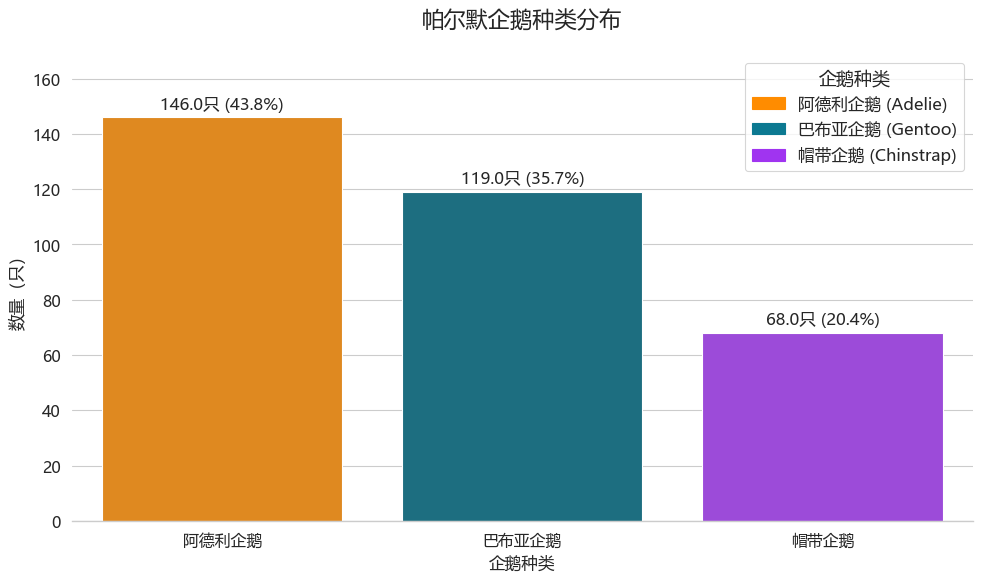

In [4]:
# 企鹅种类分布
plt.figure(figsize=(10, 6))
species_count_zh = df_clean['species_zh'].value_counts()
species_order_zh = species_count_zh.index

ax = sns.countplot(
    x='species_zh',
    data=df_clean,
    order=species_order_zh,
    hue='species_zh', # 按种类着色
    palette=penguin_palette_zh,
    legend=False # 禁用自动图例，我们手动创建
)

# 添加百分比标签
total = len(df_clean)
for p in ax.patches:
    percentage = f'{(p.get_height()/total)*100:.1f}%'
    count = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height() + 3,
            f'{count}只 ({percentage})',
            ha='center', fontsize=12)

plt.title('帕尔默企鹅种类分布', fontsize=16, pad=20)
plt.xlabel('企鹅种类', fontsize=12)
plt.ylabel('数量（只）', fontsize=12)
plt.ylim(0, ax.get_ylim()[1] * 1.1)

en_name_map = {v: k for k, v in species_name_map.items()}

proxies = [mpatches.Patch(color=penguin_palette_zh[name], label=f"{name} ({en_name_map[name]})") for name in species_order_zh]

plt.legend(
    handles=proxies,
    title='企鹅种类',
    title_fontsize='13',
    fontsize='12',
    loc='upper right' 
)

sns.despine(left=True)
plt.tight_layout()
plt.show()


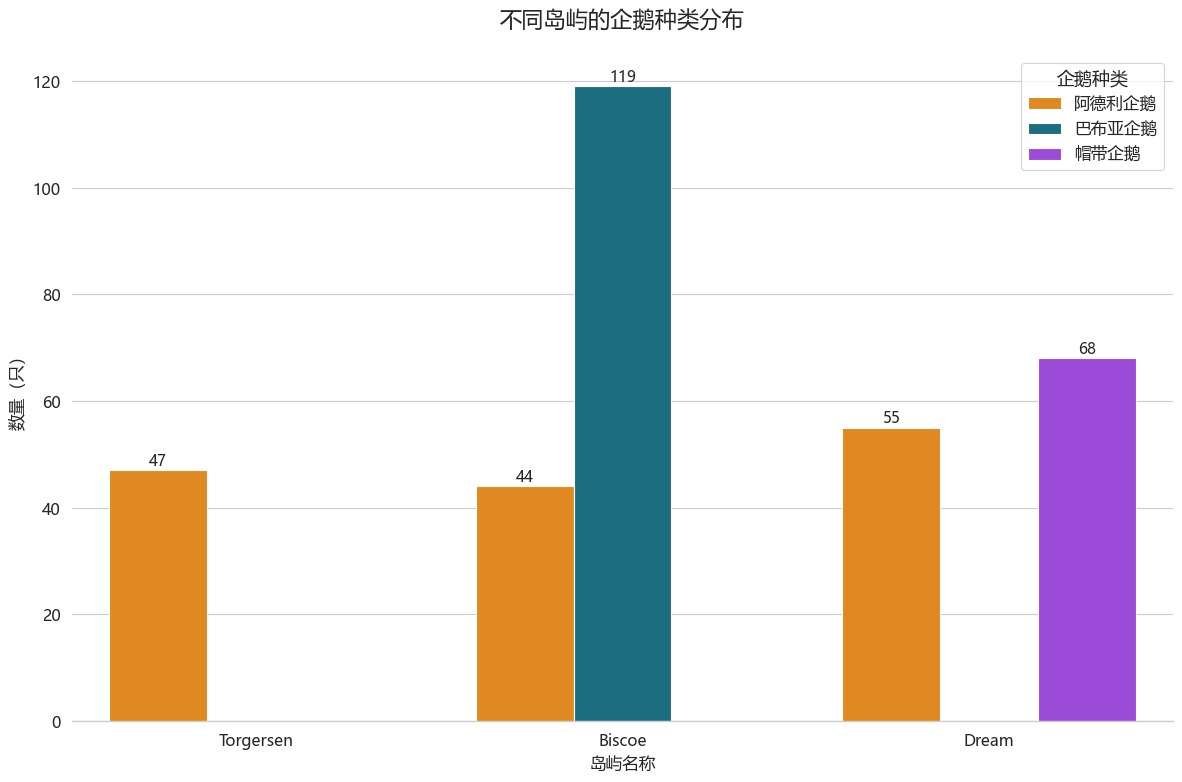

In [6]:
# 岛屿分布（按种类拆分）
plt.figure(figsize=(12, 8))
ax = sns.countplot(
    x='island',
    hue='species_zh',
    data=df_clean,
    palette=penguin_palette_zh,
    hue_order=species_order_zh
)

# 添加计数标签
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 1,
                f'{int(height)}',
                ha="center", fontsize=11)

plt.title('不同岛屿的企鹅种类分布', fontsize=16, pad=20)
plt.xlabel('岛屿名称', fontsize=12)
plt.ylabel('数量（只）', fontsize=12)
plt.legend(title='企鹅种类', title_fontsize='13', fontsize='12', loc='upper right')
sns.despine(left=True)
plt.tight_layout()
plt.show()


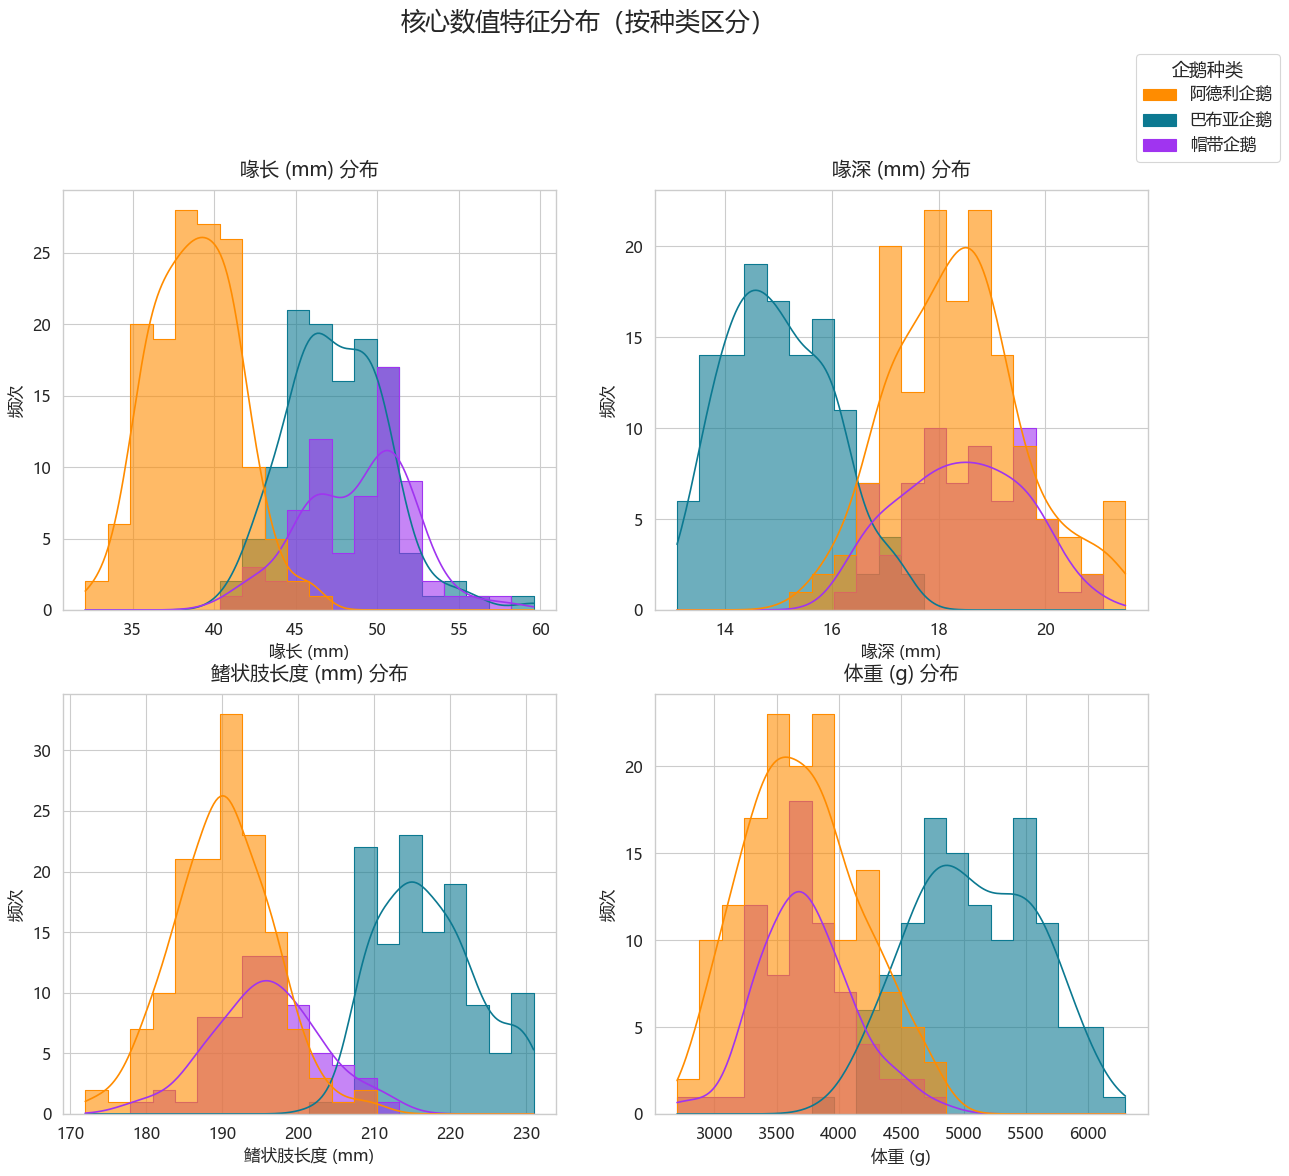

In [8]:
# 数值特征分布（按种类区分）
fig = plt.figure(figsize=(14, 12)) # 获取 figure 对象
plt.suptitle('核心数值特征分布（按种类区分）', fontsize=18, y=1.03)

label_map = {
    'culmen_length_mm': '喙长 (mm)',
    'culmen_depth_mm': '喙深 (mm)',
    'flipper_length_mm': '鳍状肢长度 (mm)',
    'body_mass_g': '体重 (g)'
}

for i, col in enumerate(numeric_cols_original):
    plt.subplot(2, 2, i + 1)
    sns.histplot(
        data=df_clean,
        x=col,
        hue='species_zh',
        palette=penguin_palette_zh,
        kde=True,
        bins=20,
        element="step",
        alpha=0.6,
        legend=False
    )
    title_zh = label_map.get(col, col)
    plt.title(f'{title_zh} 分布', fontsize=14, pad=10)
    plt.xlabel(title_zh, fontsize=12)
    plt.ylabel('频次', fontsize=12)

proxies = [mpatches.Patch(color=penguin_palette_zh[name], label=name) for name in species_order_zh]
fig.legend(
    handles=proxies,
    title='企鹅种类',
    title_fontsize='13',
    fontsize='12',
    loc='upper right',
    bbox_to_anchor=(1, 1)
)


## 2. 双变量关联分析

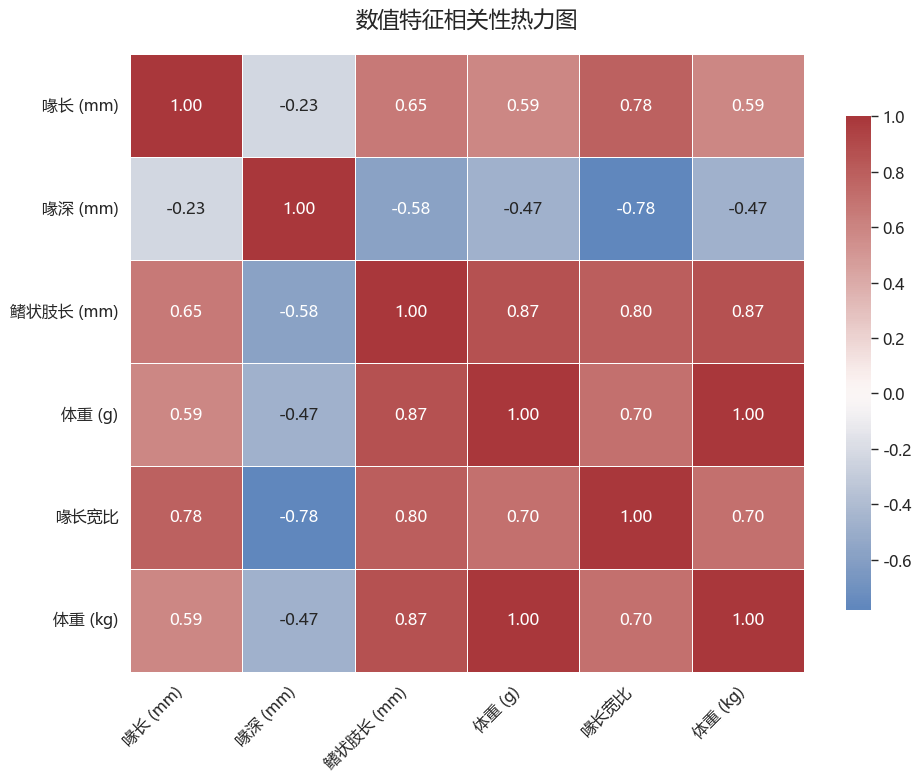

In [9]:
# 特征相关性热力图
plt.figure(figsize=(10, 8))
corr_matrix = df_clean[numeric_cols_derived].corr()

# 重命名的中文标签
corr_labels = [
    '喙长 (mm)', '喙深 (mm)', '鳍状肢长 (mm)', '体重 (g)',
    '喙长宽比', '体重 (kg)'
]

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='vlag',
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .8},
    xticklabels=corr_labels,
    yticklabels=corr_labels,
    annot_kws={"size": 12}
)
plt.title('数值特征相关性热力图', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


c:\Users\15638\anaconda3\envs\py\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\15638\AppData\Local\Temp\ipykernel_11460\2895942940.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


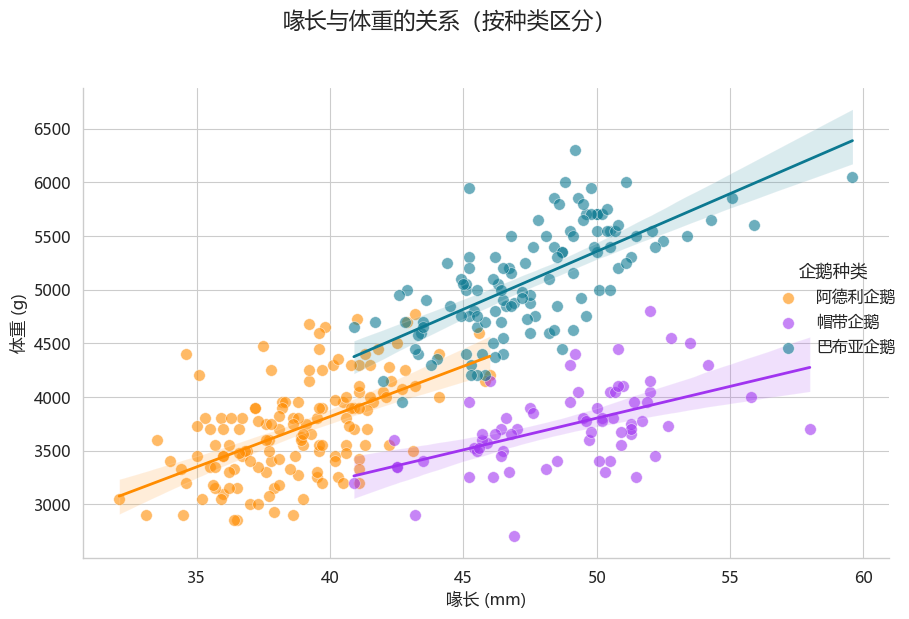

In [12]:
# 喙长 vs 体重 (升级为 lmplot)
g = sns.lmplot(
    x='culmen_length_mm',
    y='body_mass_g',
    data=df_clean,
    hue='species_zh',
    palette=penguin_palette_zh,
    height=6,
    aspect=1.3,
    scatter_kws={'s': 70, 'alpha': 0.6, 'edgecolor': 'w', 'linewidths': 0.5}, # 散点图样式
    line_kws={'lw': 2}  # 回归线样式
)
g.fig.suptitle('喙长与体重的关系（按种类区分）', fontsize=16, y=1.03)
g.set_axis_labels('喙长 (mm)', '体重 (g)', fontsize=12)
g.legend.set_title("企鹅种类")
plt.tight_layout()
plt.show()

## 3. 多维度对比分析

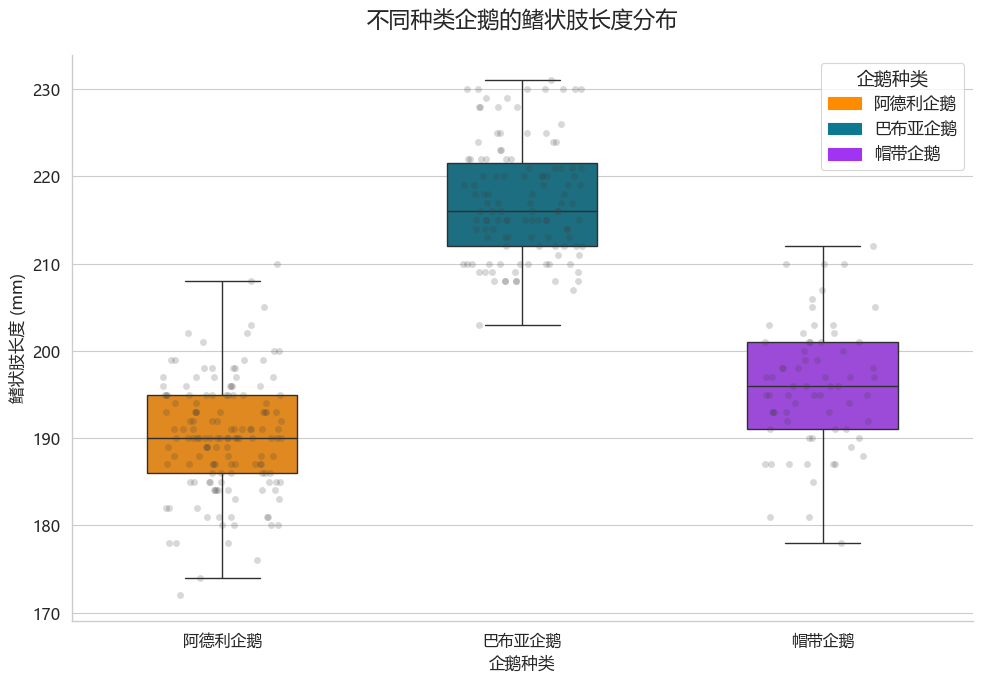

In [15]:
# 不同种类的鳍状肢长度对比 (箱线图 + 抖动散点图)
plt.figure(figsize=(10, 7))

# 绘制箱线图
ax = sns.boxplot(
    x='species_zh',
    y='flipper_length_mm',
    data=df_clean,
    order=species_order_zh,
    hue='species_zh',
    palette=penguin_palette_zh,
    width=0.5,
    showfliers=False,
    legend=False
)

# 叠加抖动散点图
sns.stripplot(
    x='species_zh',
    y='flipper_length_mm',
    data=df_clean,
    order=species_order_zh,
    color='0.25',
    alpha=0.2,
    jitter=0.2
)

plt.title('不同种类企鹅的鳍状肢长度分布', fontsize=16, pad=20)
plt.xlabel('企鹅种类', fontsize=12)
plt.ylabel('鳍状肢长度 (mm)', fontsize=12)


proxies = [mpatches.Patch(color=penguin_palette_zh[name], label=name) for name in species_order_zh]
plt.legend(
    handles=proxies,
    title='企鹅种类',
    title_fontsize='13',
    fontsize='12',
    loc='upper right'
)


sns.despine()
plt.tight_layout()
plt.show()

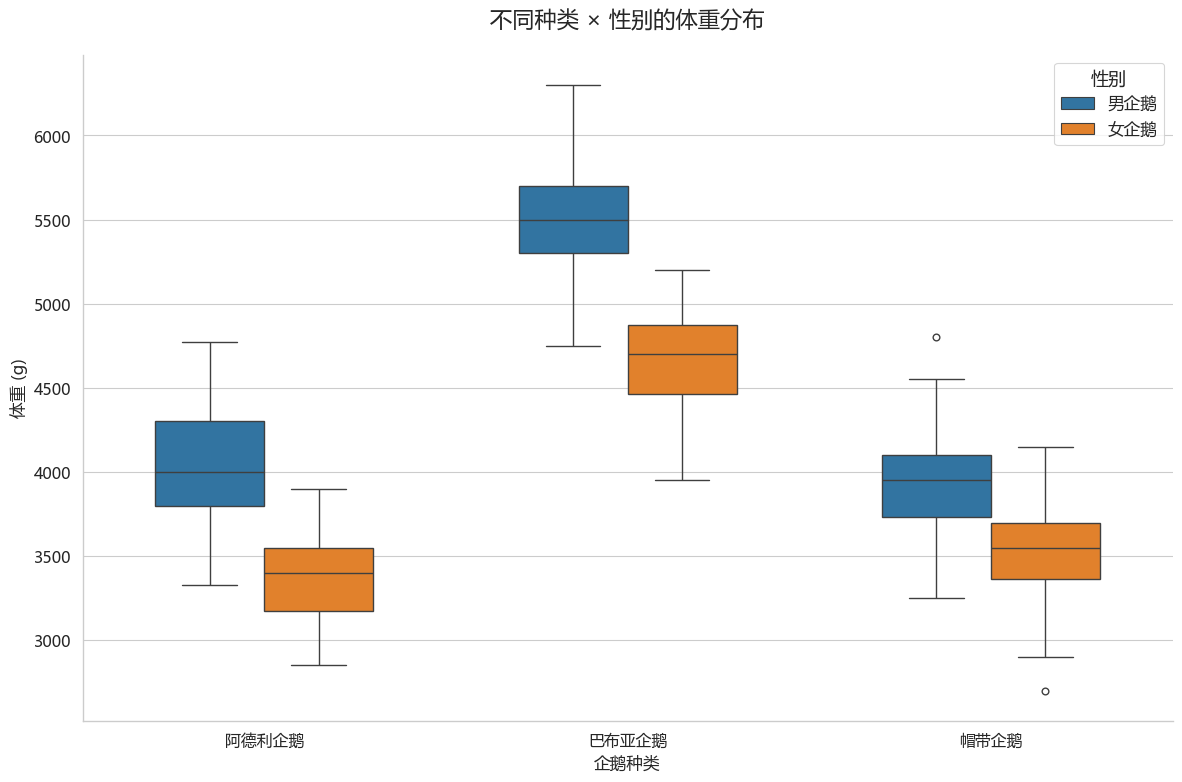

In [16]:
# 不同性别 × 种类的体重对比
plt.figure(figsize=(12, 8))
sns.boxplot(
    x='species_zh',
    y='body_mass_g',
    hue='sex_zh', # 使用中文性别列
    data=df_clean,
    order=species_order_zh,
    hue_order=['男企鹅', '女企鹅'], # 按中文顺序
    palette=sex_palette_zh, # 使用中文调色板
    width=0.6
)
plt.title('不同种类 × 性别的体重分布', fontsize=16, pad=20)
plt.xlabel('企鹅种类', fontsize=12)
plt.ylabel('体重 (g)', fontsize=12)
plt.legend(title='性别', title_fontsize='13', fontsize='12', loc='upper right') # 统一位置
sns.despine()
plt.tight_layout()
plt.show()

c:\Users\15638\anaconda3\envs\py\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


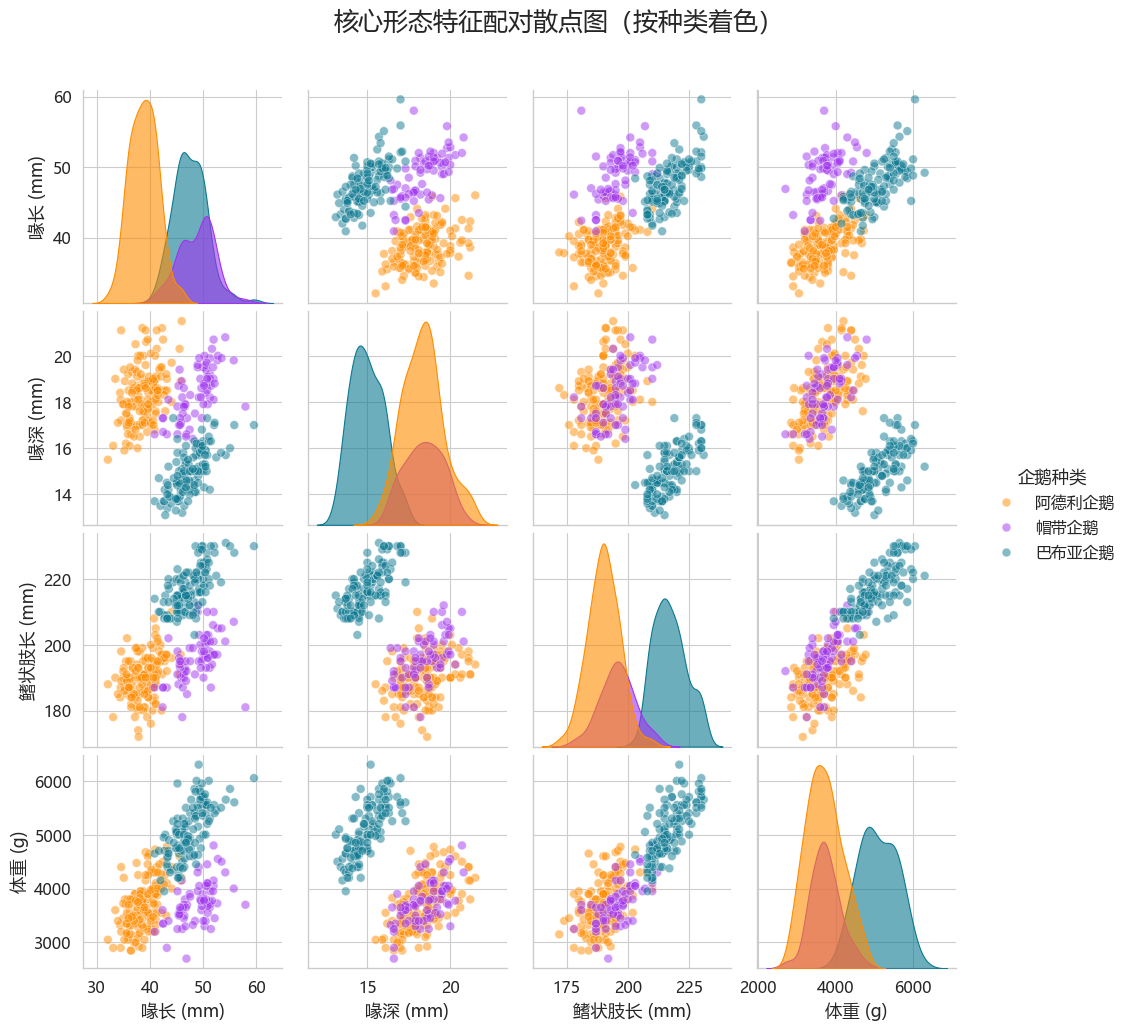

In [17]:
# 多特征配对散点图（按种类着色）

df_pairplot = df_clean[numeric_cols_original + ['species_zh']].copy()
df_pairplot.columns = ['喙长 (mm)', '喙深 (mm)', '鳍状肢长 (mm)', '体重 (g)', '企鹅种类']

g = sns.pairplot(
    df_pairplot,
    hue='企鹅种类',
    palette=penguin_palette_zh,
    diag_kind='kde',     # 对角线显示核密度图
    plot_kws={'s': 40, 'alpha': 0.5, 'edgecolor': 'w', 'linewidth': 0.5},
    diag_kws={'fill': True, 'alpha': 0.6}
)
g.fig.suptitle('核心形态特征配对散点图（按种类着色）', fontsize=18, y=1.03)
g._legend.set_title("企鹅种类")
plt.subplots_adjust(top=0.95, right=0.85)
plt.show()

# 数据预处理 (第2部分：标准化与编码)
# 这一部分是为了后续的机器学习建模

In [18]:
print("\n--- 开始为建模进行预处理 ---")
# 分离数值特征和分类特征
numeric_cols_to_scale = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'culmen_ratio', 'body_mass_kg']
category_cols_to_encode = ['species', 'island', 'sex', 'species_zh', 'sex_zh'] # 包含所有分类列

print(f"待标准化列: {numeric_cols_to_scale}")
print(f"待编码列: {category_cols_to_encode}")

# 步数值特征标准化（Z-Score）
scaler = StandardScaler()
df_clean[numeric_cols_to_scale] = scaler.fit_transform(df_clean[numeric_cols_to_scale])

# 分类特征编码（标签编码）
label_encoders = {}
for col in category_cols_to_encode:
    le = LabelEncoder()
    df_clean[f'{col}_encoded'] = le.fit_transform(df_clean[col])
    label_encoders[col] = le
    # 打印映射关系，确保中文显示正常
    mapping_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"'{col}' 编码映射: {mapping_dict}")


# 验证标准化和编码结果
print("\n标准化与编码后数据示例：")
encoded_cols = [f'{c}_encoded' for c in category_cols_to_encode]
print(df_clean[numeric_cols_to_scale + encoded_cols].head(3))

# 保存为新文件，供后续建模使用
output_filename = 'penguins_ml_processed.csv'
df_clean.to_csv(output_filename, index=False)
print(f"\n预处理完成！已保存为 {output_filename}")


--- 开始为建模进行预处理 ---
待标准化列: ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'culmen_ratio', 'body_mass_kg']
待编码列: ['species', 'island', 'sex', 'species_zh', 'sex_zh']
'species' 编码映射: {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}
'island' 编码映射: {'Biscoe': 0, 'Dream': 1, 'Torgersen': 2}
'sex' 编码映射: {'FEMALE': 0, 'MALE': 1}
'species_zh' 编码映射: {'巴布亚企鹅': 0, '帽带企鹅': 1, '阿德利企鹅': 2}
'sex_zh' 编码映射: {'女企鹅': 0, '男企鹅': 1}

标准化与编码后数据示例：
   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
0         -0.896042         0.780732          -1.426752    -0.568475   
1         -0.822788         0.119584          -1.069474    -0.506286   
2         -0.676280         0.424729          -0.426373    -1.190361   

   culmen_ratio  body_mass_kg  species_encoded  island_encoded  sex_encoded  \
0     -1.043718     -0.568475                0               2            1   
1     -0.681461     -0.506286                0               2            0   
2     -0.744583     -1